# Doing some Imports

In [ ]:
import numpy as np
import pickle
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
import tensorflow as tf

# Import necessary items from Keras
from keras.layers import Activation, Dropout, UpSampling2D, Flatten
from keras.layers import Conv2DTranspose, Conv2D, MaxPool2D
from keras.layers import BatchNormalization
from tensorflow.keras import Input
from keras.layers import concatenate
from keras.preprocessing.image import ImageDataGenerator
from keras import regularizers, Model
from keras.losses import MeanSquaredError as mse
from tensorflow.keras.optimizers import Adam

#debugging imports
import matplotlib.pyplot as plt
%matplotlib inline

**Connecting our Google Colab to the drive where our dataset is.**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Create your model

Setting up our U-net components (Convolutional and Deconvolutional blocks). We are going to be using "same" padding and activation "relu" accross our model. The last conv2D layer uses the "sigmoid" activation function since we are dealing with only one class. 

In [ ]:
# Setting up Conv2D block which we will be using in the first half of the U-net architecture. 

def conv_block(tensor, nfilters, size=3):                      # default kernel size = 3
    x = Conv2D(filters=nfilters, kernel_size=(size, size), padding='same', kernel_initializer="he_normal")(tensor)
    x = Activation("relu")(x)
    x = Conv2D(filters=nfilters, kernel_size=(size, size), padding='same', kernel_initializer="he_normal")(x)
    x = Activation("relu")(x)
    return x

In [ ]:
# Setting up Deconvolutional block which we will use after the Convolutional blocks. 

def deconv_block(tensor, residual, nfilters, size=3):           # default kernel size = 3
    y = Conv2DTranspose(nfilters, kernel_size=(size, size), strides=(2, 2), padding='same')(tensor)
    y = concatenate([y, residual], axis=3)
    y = conv_block(y, nfilters)
    return y

In [ ]:
def create_model(input_shape, filters=64):

    input_layer = Input(shape=input_shape, name='image_input')
    x = BatchNormalization()(input_layer)

    # Downsampling block 

    conv1 = conv_block(x, nfilters=filters)
    conv1_out = MaxPool2D(pool_size=(2, 2))(conv1)
    conv2 = conv_block(conv1_out, nfilters=filters*2)
    conv2_out = MaxPool2D(pool_size=(2, 2))(conv2)
    conv3 = conv_block(conv2_out, nfilters=filters*4)
    conv3_out = MaxPool2D(pool_size=(2, 2))(conv3)
    conv4 = conv_block(conv3_out, nfilters=filters*8)
    conv4_out = MaxPool2D(pool_size=(2, 2))(conv4)
    conv4_out = Dropout(0.6)(conv4_out)           # After some trials, we figured 0.6 Dropout is optimal.
    conv5 = conv_block(conv4_out, nfilters=filters*16)
    conv5 = Dropout(0.6)(conv5)

    # Upsampling block

    deconv6 = deconv_block(conv5, residual=conv4, nfilters=filters*8)
    deconv6 = Dropout(0.6)(deconv6)
    deconv7 = deconv_block(deconv6, residual=conv3, nfilters=filters*4)
    deconv7 = Dropout(0.6)(deconv7) 
    deconv8 = deconv_block(deconv7, residual=conv2, nfilters=filters*2)
    deconv9 = deconv_block(deconv8, residual=conv1, nfilters=filters)

    # Output Conv layer with "sigmoid" activation layer

    output_layer = Conv2D(filters=1, kernel_size=(1, 1))(deconv9)
    output_layer = Activation('sigmoid')(output_layer)

    model = Model(inputs=input_layer, outputs=output_layer)
    return model

## Load the data

Nothing really matters.

In [ ]:
# def rgb2gray(train_images):
#   gray=np.full((train_images.shape(1),train_images.shape(2)), 0)
#   for rgb in train_images:
#     for i in range(train_images.shape(1)):  
#       for j in range(train_images.shape(2)):
#         r, g, b = rgb[:,:,0], rgb[:,:,1], rgb[:,:,2]
#         gray[i][j] = 0.2989 * r + 0.5870 * g + 0.1140 * b
  
#   return gray

Text(0.5, 1.0, 'label')

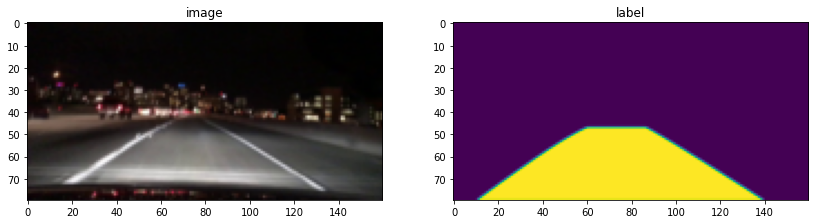

In [ ]:
# Load training images

train_images = pickle.load(open("drive/MyDrive/trainset/full_CNN_train.p", "rb" ))

# Load image labels
labels = pickle.load(open("drive/MyDrive/trainset/full_CNN_labels.p", "rb" ))

# Make into arrays as the neural network wants these
train_images = np.array(train_images)
labels = np.array(labels)

# testing the dataset
fig, arr = plt.subplots(1, 2, figsize=(14, 10))

index = 21

arr[0].imshow(train_images[index])
arr[0].set_title("image")

arr[1].imshow(labels[index,:,:,0])
arr[1].set_title("label")


## Preprocess the data

In the preprocessing phase, we applied data normalization and augmentation. We used the "brightness_range" to vary the brightness in the image so it yields us better results while training. Additionaly, we used "channel_shift_range" to further normalize the data but with a very low value since it's already normalized.   

In [ ]:
# TODO: Preprocess the images

labels = labels / 255               # Data normalization
datagen = ImageDataGenerator(
    brightness_range=(0.05,1.5),
    channel_shift_range=0.1
    )


[0.         0.00392157 0.00784314 0.01176471 0.01568627 0.01960784
 0.02352941 0.02745098 0.03137255 0.03529412 0.03921569 0.04313725
 0.04705882 0.05490196 0.05882353 0.07058824 0.0745098  0.07843137
 0.08235294 0.08627451 0.09019608 0.09411765 0.09803922 0.10980392
 0.11372549 0.12156863 0.1254902  0.13333333 0.14901961 0.15294118
 0.16078431 0.17254902 0.17647059 0.18039216 0.18431373 0.20392157
 0.20784314 0.21176471 0.21568627 0.23529412 0.24705882 0.25098039
 0.25882353 0.2627451  0.26666667 0.27843137 0.29803922 0.31764706
 0.32156863 0.32941176 0.3372549  0.34509804 0.34901961 0.35294118
 0.37254902 0.37647059 0.38039216 0.38431373 0.38823529 0.39607843
 0.4        0.41176471 0.41960784 0.43529412 0.43921569 0.45098039
 0.45882353 0.4627451  0.47058824 0.4745098  0.49411765 0.50196078
 0.50980392 0.52156863 0.5254902  0.54117647 0.54901961 0.56078431
 0.56862745 0.58823529 0.61568627 0.63137255 0.63529412 0.64705882
 0.65490196 0.67058824 0.67843137 0.68627451 0.69803922 0.7019

## Create the train and test splits

In [ ]:
# Shuffle images along with their labels, then split into training/validation sets
train_images, labels = shuffle(train_images, labels)
# Test size may be 10% or 20%
X_train, X_val, y_train, y_val = train_test_split(train_images, labels, test_size=0.1)


## Train your model

For the training phase of our model, we used "Adam" optimizer, with the "mse" loss function after comparing it with the "binary_cross_entropy". We also tuned some of the hyperparameters that "Adam" optimization function takes like the *learning rate, beta_1, beta_2 and epsilon*. Finally, we have chosen the number of epochs and batch size for the training model after trying multiple values and comparing the results.  

In [ ]:
# TODO: Train your model

batch_size=32
epochs = 20
lr = 0.0007
eps = 1e-08


input_shape=np.shape(train_images[0])

model = create_model((80, 160, 3))
optimizer = tf.keras.optimizers.Adam(learning_rate = lr,
                                     beta_1 = 0.88, 
                                     beta_2 = 0.995, 
                                     epsilon = eps)

model.compile(
            loss='mse',
            optimizer=optimizer,
            metrics=['accuracy'])

model_history = model.fit(
        datagen.flow(X_train, y_train, batch_size=batch_size),
        validation_data=(X_val, y_val),
        steps_per_epoch=len(X_train)/batch_size,      # We set the steps_per_epoch to vary accroding to the number of the training samples and the predefined batch size
        epochs=epochs)


Epoch 1/20
358/358 [==============================] - 305s 789ms/step - loss: 0.0196 - accuracy: 0.9437 - val_loss: 0.0054 - val_accuracy: 0.9608
Epoch 2/20
358/358 [==============================] - 265s 739ms/step - loss: 0.0058 - accuracy: 0.9602 - val_loss: 0.0045 - val_accuracy: 0.9614
Epoch 3/20
358/358 [==============================] - 265s 739ms/step - loss: 0.0056 - accuracy: 0.9603 - val_loss: 0.0046 - val_accuracy: 0.9614
Epoch 4/20
358/358 [==============================] - 264s 735ms/step - loss: 0.0048 - accuracy: 0.9610 - val_loss: 0.0041 - val_accuracy: 0.9618
Epoch 5/20
358/358 [==============================] - 264s 735ms/step - loss: 0.0048 - accuracy: 0.9609 - val_loss: 0.0040 - val_accuracy: 0.9617
Epoch 6/20
358/358 [==============================] - 264s 736ms/step - loss: 0.0043 - accuracy: 0.9613 - val_loss: 0.0038 - val_accuracy: 0.9619
Epoch 7/20
358/358 [==============================] - 265s 737ms/step - loss: 0.0042 - accuracy: 0.9614 - val_loss: 0.0036 -

## Save your model

Visualizing our model's performance through the "accuracy" metric.

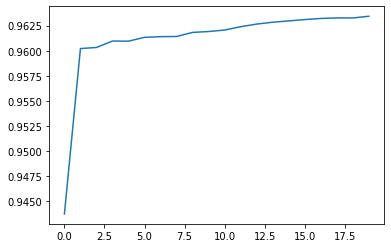

In [ ]:
plt.plot(model_history.history["accuracy"])

In [ ]:
# Save model architecture and weights
model.save('full_CNN_model.h5')

# Show summary of model
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 image_input (InputLayer)       [(None, 80, 160, 3)  0           []                               
                                ]                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 80, 160, 3)  12          ['image_input[0][0]']            
 alization)                                                                                       
                                                                                                  
 conv2d (Conv2D)                (None, 80, 160, 64)  1792        ['batch_normalization[0][0]']    
                                                                                              